In [1]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Georgia']})
rc('text', usetex=True)

In [2]:
from helper import *
from utils import *
from approximation import *
from plot import *

In [3]:
def load_contour_dist_2d(file_pattern, grid_size, n_sample):
    """
    Load likelihood ratio test statistic distributions from simulated data files.
    """
    contour_dist = np.zeros((grid_size, grid_size, n_sample))
    for i in range(grid_size * grid_size):
        j = i / grid_size
        k = i % grid_size
        loglik_global = []
        loglik_profile = []
        try:
            # TODO: file_pattern seems like a dumb way of handling files
            with open(file_pattern + '_{a}.{b}_of_400.txt'.format(a=i, b=i + 1), 'r') as f:
                for line in f:
                    if len(line.split(',')) == 12:
                        loglik_global.append(float(line.split(',')[10][1:]))
                        loglik_profile.append(float(line.split(',')[11][1:-2]))
            loglik_global = np.asarray(loglik_global)
            loglik_profile = np.asarray(loglik_profile)
            lrt = 2 * (loglik_profile - loglik_global)  # distribution of likelihood ratio test statistic
            n = lrt.shape[0]
            if n < n_sample:  # not enough
                contour_dist[j, k, :n] = lrt
                contour_dist[j, k, n:] = -1
            else:
                contour_dist[j, k, :] = lrt[:n_sample]
        except:
            print(i)
            contour_dist[j, k, :] = contour_dist[j, k - 1, :]  # catch occasional missing data files
    return contour_dist

In [4]:
def load_contour_stat_2d(file_path, grid_size):
    """
    Load contour of fitted LRT statistic from data in text file.
    """
    loglik_global = []
    loglik_profile = []
    with open(file_path, 'r') as f:
        for line in f:
            loglik_global.append(float(line.split(',')[10][1:]))
            loglik_profile.append(float(line.split(',')[11][1:-2]))
    loglik_global = np.asarray(loglik_global)
    loglik_profile = np.asarray(loglik_profile)
    contour_stat = np.zeros((grid_size, grid_size))
    # TODO: implement 1d version
    for i in range(grid_size * grid_size):
        j = i / grid_size
        k = i % grid_size
        contour_stat[j, k] = 2 * (loglik_profile[i] - np.min(loglik_profile))
    return contour_stat

In [5]:
directory = '/Users/linggeli/Downloads/'
contour_type = 'theta23__dmsq_32_NH'

In [6]:
contour_dist = load_contour_dist_2d(directory + 'fc/{}/contour'.format(contour_type), 20, 2000)

In [7]:
data_index = 0

In [8]:
contour_stat = load_contour_stat_2d(directory + 'contours/{c}/fit_{i}.txt'.format(c=contour_type, i=data_index), 20)

In [9]:
contour_tile = calculate_percentile_2d(contour_dist, contour_stat)  # p-value at every point

In [10]:
all_points, all_samples = flatten_dist(contour_dist)
all_obs = contour_stat.flatten()

In [11]:
n_mc = 0
total = 20 * 20 * 2000
priority = np.random.uniform(size=400)  # uniform priority means random sampling
sample_size = np.zeros(400)

In [12]:
for run in range(5):
    n_mc += 80 * 200
    
    sample_size = expand_sample(priority, sample_size, 80, 200, 2000)
    current_points = get_current_training(all_points, sample_size)
    current_target, current_error = get_current_target(all_samples, all_obs, sample_size)
    hat, std = build_approximation(current_points, current_target, current_error, all_points)
    priority = acquisition_function(hat, std)
    
    hat[sample_size > 0] = current_target  # replace model approximation with sample estimate when possible
    hat_grid = data_to_grid(hat, 20)
    
    overlap = calculate_overlap(hat_grid, contour_tile)
    print('{} per cent Monte Carlo\n'.format(n_mc * 100.0 / total) + '{} per cent overlap'.format(np.round(overlap * 100, 3)))

2.0 per cent Monte Carlo
92.375 per cent overlap
4.0 per cent Monte Carlo
93.25 per cent overlap
6.0 per cent Monte Carlo
93.375 per cent overlap
8.0 per cent Monte Carlo
93.375 per cent overlap
10.0 per cent Monte Carlo
93.5 per cent overlap


In [13]:
from tqdm import tqdm as tqdm

In [14]:
total_overlap = np.zeros((200, 10))

for data_index in tqdm(range(200)):
    contour_stat = load_contour_stat_2d(directory + 'contours/{c}/fit_{i}.txt'.format(c=contour_type, i=data_index), 20)
    contour_tile = calculate_percentile_2d(contour_dist, contour_stat)  # p-value at every point
    
    all_points, all_samples = flatten_dist(contour_dist)
    all_obs = contour_stat.flatten()
    
    priority = np.random.uniform(size=400)  # uniform priority means random sampling
    sample_size = np.zeros(400)
    for run in range(5):
        sample_size = expand_sample(priority, sample_size, 80, 200, 2000)
        current_points = get_current_training(all_points, sample_size)
        current_target, current_error = get_current_target(all_samples, all_obs, sample_size)
        hat, std = build_approximation(current_points, current_target, current_error, all_points)
        priority = acquisition_function(hat, std)

        hat[sample_size > 0] = current_target  # replace model approximation with sample estimate when possible
        hat_grid = data_to_grid(hat, 20)

        overlap = calculate_overlap(hat_grid, contour_tile)
        total_overlap[data_index, run] = overlap

 10%|▉         | 19/200 [02:11<19:54,  6.60s/it]//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([2.30128366e-04, 1.51226553e+00]), 'nit': 11, 'funcalls': 60}
  " state: %s" % convergence_dict)
 16%|█▌        | 32/200 [03:44<18:29,  6.61s/it]//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-4.55247189e-05,  6.36867940e-01]), 'nit': 14, 'funcalls': 68}
  " state: %s" % convergence_dict)
 24%|██▍       | 49/200 [05:35<17:36,  7.00s/it]//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.29842121e-04, 2

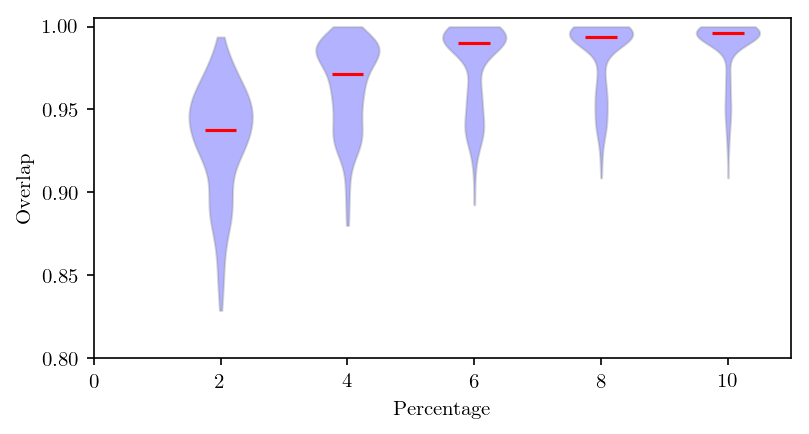

In [22]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
violin_parts = ax.violinplot([total_overlap[:, 0], 
                              total_overlap[:, 1], 
                              total_overlap[:, 2], 
                              total_overlap[:, 3], 
                              total_overlap[:, 4]], 
                             [2, 4, 6, 8, 10], 
                             widths=1, showmedians=True, showextrema=False)
plt.setp(violin_parts['bodies'], facecolor='blue', edgecolor='gray')
violin_parts['cmedians'].set_color('r')
#plt.scatter(x, results, alpha=0.1, color='b')
plt.xlim(0, 11)
plt.ylim(0.8, 1.005)
plt.xlabel('Percentage')
plt.ylabel('Overlap')
#plt.savefig('comparison.png')
plt.show()